## Exploration of the Titanic Data Set using Decision Trees

In [35]:
# importing libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

import matplotlib.pyplot as plt

### Section 1 - Data Cleaning

In [36]:
# Load titanic data set & check the data set
df = pd.read_csv('titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [37]:
# check for missing data
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Out of 891 rows, 177 entries are missing for 'Age' and 687 entries for 'Cabin'. Since it is unlikely that we'll be able to impute the missing data due to the large numbers, we'll drop entries with missing values under 'Age' and 'Cabin' columns. Furthermore, other columns that are deemed to be unlikely to influence the survival rate of a passenger are dropped: 'PassengerId', 'Name', 'Ticket', 'Cabin'.

In [38]:
df.dropna(subset=['Age'], inplace=True)
df.dropna(subset=['Embarked'], inplace=True)
df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
889,1,1,male,26.0,0,0,30.0000,C


There are now 712 rows x 8 columns. This is still a considerably large amount of data.
</br>Next, data under 'Sex' and 'Embarked' can be encoded into dummy numerical variables. But, first, we'll check how many unique values under 'Embarked' there are:

In [39]:
df['Embarked'].value_counts()

S    554
C    130
Q     28
Name: Embarked, dtype: int64

- There are 3 unique values (ports) for 'Embarked'. Therefore, they are encoded as 0, 1, 2.
- Similarly, under 'Sex', 'male' and 'female' are encoded as 0 and 1, respectively.

In [40]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Sex'].apply(pd.to_numeric, errors='coerce')

df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df['Embarked'].apply(pd.to_numeric, errors='coerce')

df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
885,0,3,1,39.0,0,5,29.1250,2
886,0,2,0,27.0,0,0,13.0000,0
887,1,1,1,19.0,0,0,30.0000,0
889,1,1,0,26.0,0,0,30.0000,1


In [41]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,0.363764,29.642093,0.514045,0.432584,34.567251,0.261236
std,0.491139,0.836854,0.481420,14.492933,0.930692,0.854181,52.938648,0.521561
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.000000,0.000000,0.000000,8.050000,0.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000,15.645850,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.000000,0.000000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200,2.000000


Now that the data set has been cleaned, it is ready for further analyses using decision trees

### Section 2 - Decision Trees (without pruning)

For the dependent variable (y), we want to predict the survival rate ('Survived', column index 0). The other columns (index 1 -7) are the independent variables (x).

In [42]:
x = df.iloc[:,1:8].values
y = df.iloc[:,0].values

x = x.reshape(-1, 7)
y = y.reshape(-1,1)

<br/> The data set is then split into: training (x_train, 60%), development / validation (x_val, 20%), and test sets (x_test, 20%).
<br/> The validation set will be used to test the accuracy of the training set to ensure the model is not over/underfitted.

In [43]:
# value for random state
r = 6

# Set aside 20% of training set for test set
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, shuffle = True, random_state = r)

# Use the same function above and set aside another 20% from the training set for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state= r) # 0.25 x 0.8 = 0.2

# The split now is 60% (x_train), 20% (x_test), 20% (x_val)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: (426, 7)
y_train shape: (426, 1)
x_test shape: (143, 7)
y_test shape: (143, 1)
x_val shape: (143, 7)
y_val shape: (143, 1)


A decision tree model is then trained on x_train without any pruning, and the accuracy is measured on the validation set (x_val) and printed, togther with the overall depth of the model. Next, the decision tree is plotted for visualisation.

Performance without pruning: 0.7342657342657343
At depth: 18


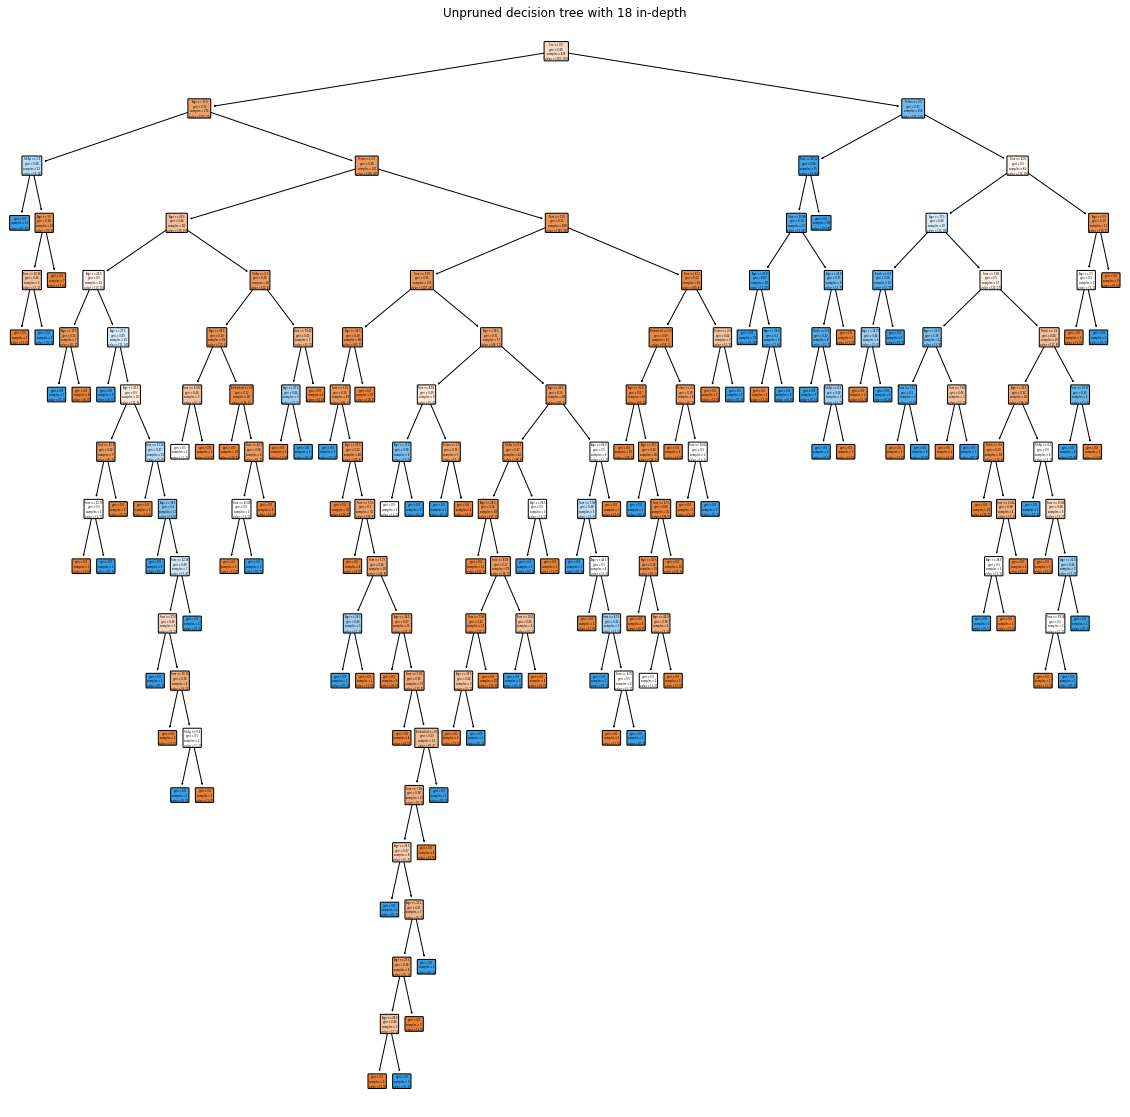

In [44]:
# Training a model without pruning
unpruned = DecisionTreeClassifier(max_depth=None, random_state=r)
unpruned.fit(x_train, y_train)
print("Performance without pruning:", unpruned.score(x_val, y_val))
print("At depth:", unpruned.tree_.max_depth)

features = list(df.columns[1:8])

# Visualising the decision tree without pruning.
fig = plt.figure(figsize = (20,20))
tree.plot_tree(unpruned,feature_names= features, rounded = True, proportion = False, precision = 2, filled = True)
plt.title(f"Unpruned decision tree with {unpruned.tree_.max_depth} in-depth")
plt.show()

Without pruning, the decision tree reaches a depth of 18 and is difficult to rationalise. The score of the unprunned tree classifier is around 0.7 on the validation set. Next, The accuracy at various depth levels are visualised below to help us decide on a possible optimum depth level.

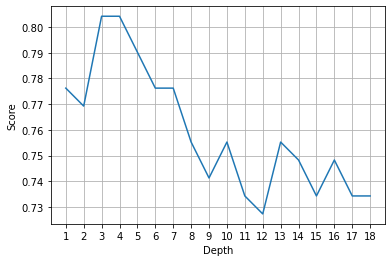

In [45]:
# looking at effect of pruning   
pruned_depths = range(1,unpruned.tree_.max_depth+1)

pruned_scores = [] 
for d in pruned_depths:
  clf = DecisionTreeClassifier(max_depth=d, random_state=r)
  clf.fit(x_train, y_train)
  score = clf.score(x_val, y_val)
  pruned_scores.append(score)

fig, ax = plt.subplots()
ax.plot(pruned_depths, pruned_scores)
plt.xlabel("Depth")
plt.ylabel("Score")
plt.grid()
ax.xaxis.set_ticks(pruned_depths)
plt.show()

From the graph above, we can see that the highest score on the validation set is reached at a depth of 3. Perhaps, beyond 3 in depth, the model is overfitted with less explanation/generalisation power. Next, decision trees are constructed at various depth levels.

### Section 3 - Decision Trees (with various levels of pruning)

Now, we will look at the effects of pruning by visualising the trees at different depths (2, 3, 5, and 8).

Decision tree of 2 in-depth using validation data (Score: 0.7692307692307693)


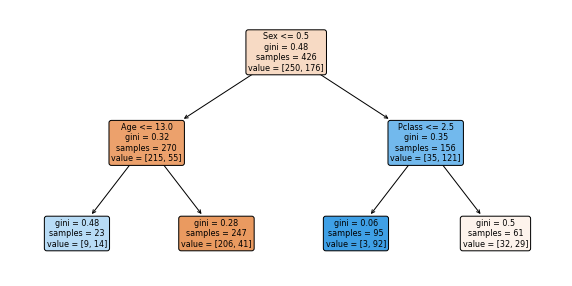

In [46]:
depth = 2
pruned1 = DecisionTreeClassifier(max_depth=depth)
pruned1.fit(x_train, y_train)
score = pruned1.score(x_val, y_val)

fig = plt.figure(figsize=(10,5))
print(f"Decision tree of {depth} in-depth using validation data (Score: {score})")
tree.plot_tree(pruned1,feature_names= features, fontsize=8, rounded = True, proportion = False, precision = 2, filled = True)
plt.show()

Decision tree of 3 in-depth using validation data (Score: 0.8041958041958042)


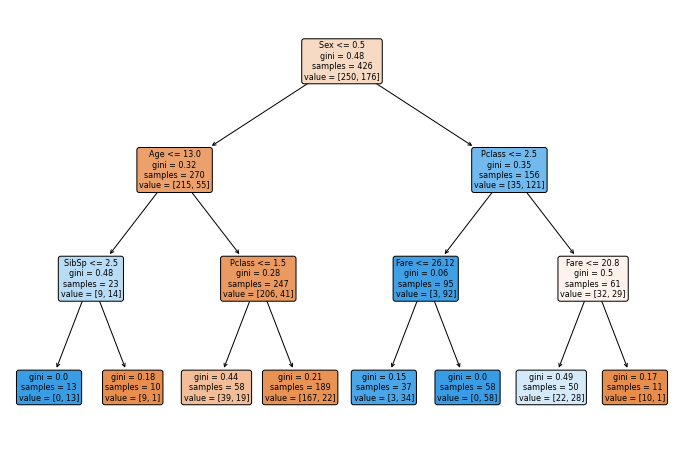

In [47]:
depth = 3
pruned1 = DecisionTreeClassifier(max_depth=depth)
pruned1.fit(x_train, y_train)
score = pruned1.score(x_val, y_val)

fig = plt.figure(figsize=(12,8))
print(f"Decision tree of {depth} in-depth using validation data (Score: {score})")
tree.plot_tree(pruned1,feature_names= features, fontsize=8, rounded = True, proportion = False, precision = 2, filled = True)
plt.show()

Decision tree of 5 in-depth using validation data (Score: 0.8111888111888111)


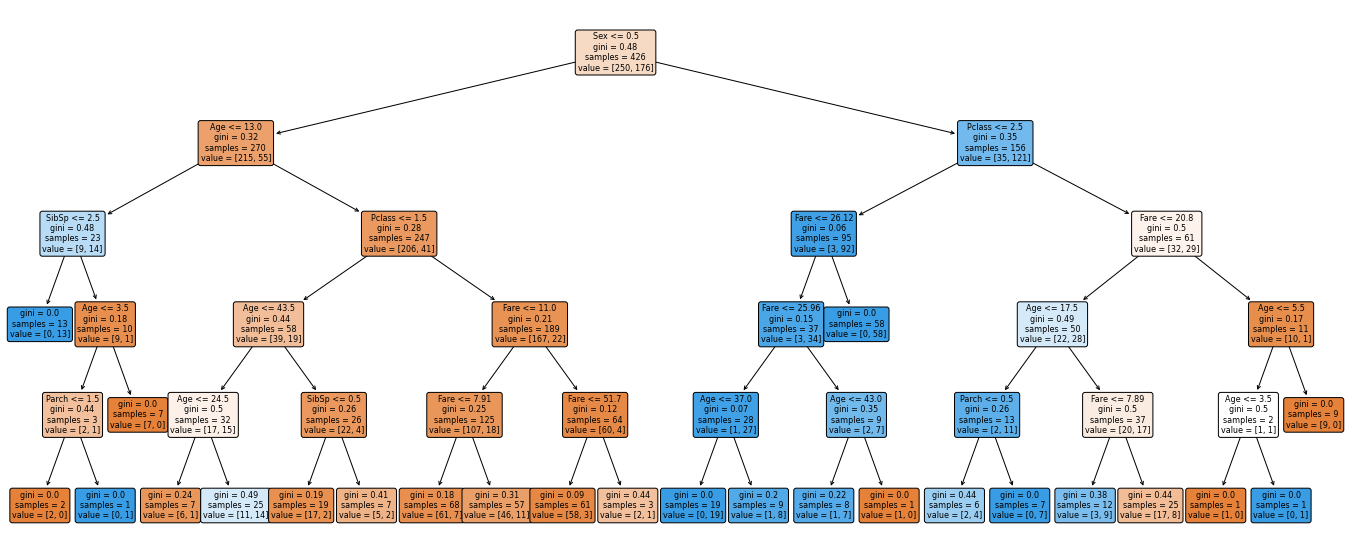

In [48]:
depth = 5
pruned1 = DecisionTreeClassifier(max_depth=depth)
pruned1.fit(x_train, y_train)
score = pruned1.score(x_val, y_val)

fig = plt.figure(figsize=(24,10))
print(f"Decision tree of {depth} in-depth using validation data (Score: {score})")
tree.plot_tree(pruned1,feature_names= features, fontsize=8, rounded = True, proportion = False, precision = 2, filled = True)
plt.show()

Decision tree of 8 in-depth using validation data (Score: 0.7622377622377622)


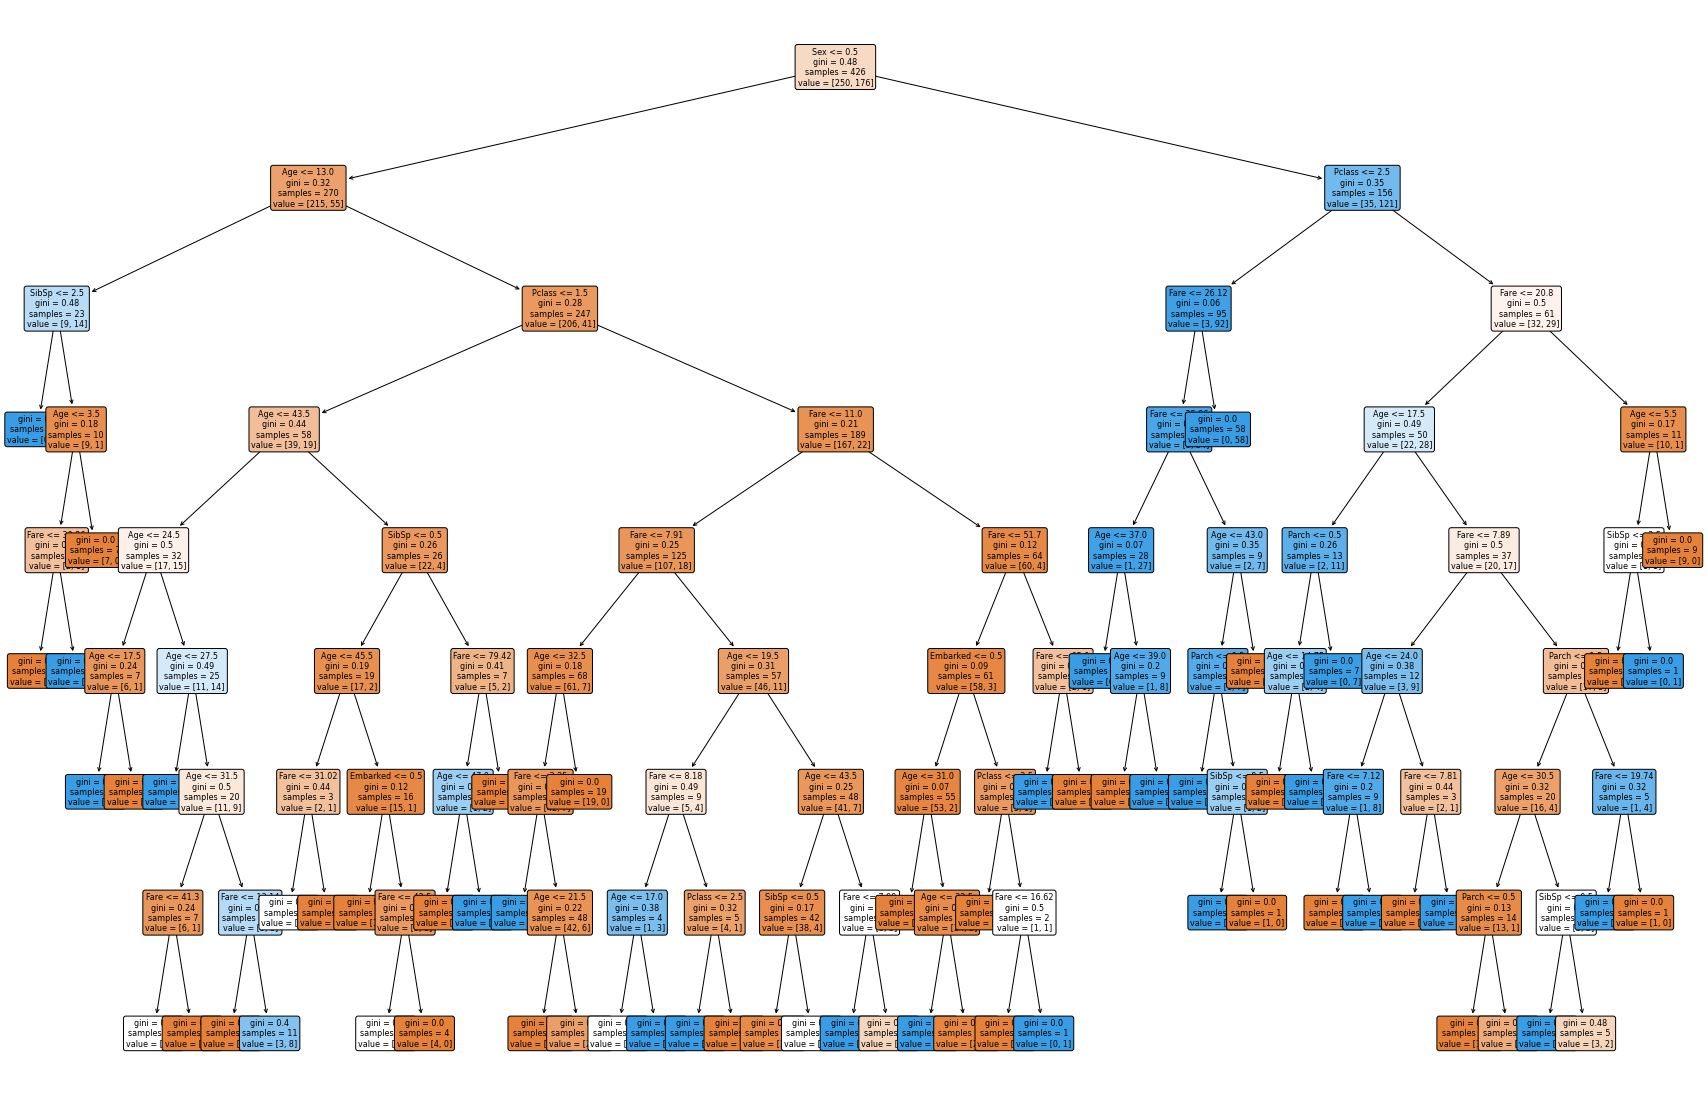

In [49]:
depth = 8
pruned1 = DecisionTreeClassifier(max_depth=depth)
pruned1.fit(x_train, y_train)
score = pruned1.score(x_val, y_val)

fig = plt.figure(figsize=(30,20))
print(f"Decision tree of {depth} in-depth using validation data (Score: {score})")
tree.plot_tree(pruned1,feature_names= features, fontsize=8, rounded = True, proportion = False, precision = 2, filled = True)
plt.show()

To understand the differences between the scores from the training and development set, they are plotted on the graphs below.

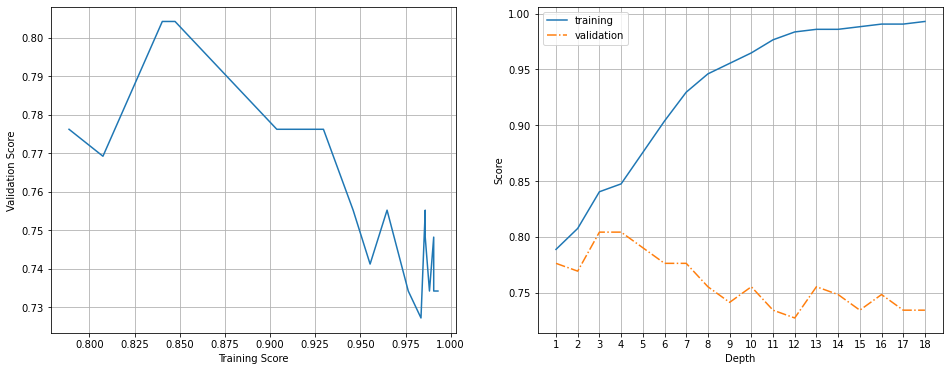

In [50]:
pruned_depths = range(1,unpruned.tree_.max_depth+1)
training_score = [] 
validation_score = []

for d in pruned_depths:
  clfg = DecisionTreeClassifier(max_depth=d, random_state=r)
  clfg.fit(x_train, y_train)
  score1 = clfg.score(x_train, y_train)
  training_score.append(score1)
  score2 = clfg.score(x_val, y_val)
  validation_score.append(score2)
  
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(training_score, validation_score)
ax[0].set_ylabel("Validation Score")
ax[0].set_xlabel("Training Score")
ax[0].grid()

ax[1].plot(pruned_depths, training_score)
ax[1].plot(pruned_depths, validation_score, '-.')
ax[1].legend(['training', 'validation'])
ax[1].set_ylabel("Score")
ax[1].set_xlabel("Depth")
ax[1].set_xticks(pruned_depths)
ax[1].grid()

plt.show()

With increasing depths, as the training set score approaches 1 (as it is expected for a training set), the score from the validation set peaks at a depth of 3. Beyond this, the score of the validation set slowly declines. Because of this, it is decided that the optimum depth is 3, and this decision tree classifier model is then used on the test set (below).

Best performance reached at depth of: 3
Decision tree of 3 in-depth using test data (Score: 0.8531468531468531)


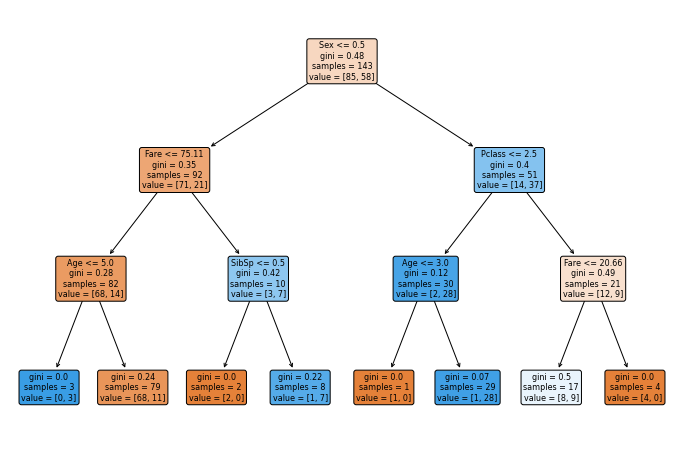

In [51]:
# Fitting the a decision tree with a depth of 3 on the test set.
best_depth = pruned_depths[np.argmax(validation_score)]
print(f'Best performance reached at depth of: {best_depth}')

best_pruned = DecisionTreeClassifier(max_depth=best_depth)
best_pruned.fit(x_test, y_test)
best_score = best_pruned.score(x_test, y_test)

fig = plt.figure(figsize=(12,8))
print(f"Decision tree of {best_depth} in-depth using test data (Score: {best_score})")
tree.plot_tree(best_pruned,feature_names= features, fontsize=8, rounded = True, proportion = False, precision = 2, filled = True)
plt.show()

### Section 4 - Ensemble Methods
In this section, ensemble methods (Bagged, Random Forest, Boosted Tree) are explored to investigate whether the base decision tree method can be improved.
- Different decision tree models are first generated (below).
- A depth of 3 is used for the base & random forest models as it was shown to be the optimum depth from the sections above.
- 50 was initially chosen as the starting n_estimators number for the ensemble methods.

In [52]:
# The base model and the other 3 models are created.
y_train = y_train.ravel()       #to get to the correct format.

# Base model
base = DecisionTreeClassifier(max_depth=3)
base.fit(x_train,y_train)
base_pred = base.predict(x_test)

# Bagged model
bagging = BaggingClassifier(n_estimators=50, random_state=r)
bagging.fit(x_train,y_train)
bag_pred = bagging.predict(x_test)

# Random Forest model
Randomforest = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=r)
Randomforest.fit(x_train,y_train)
rf_pred = Randomforest.predict(x_test)

# Boosted Tree model
Boost = AdaBoostClassifier(n_estimators=50, random_state=r)
Boost.fit(x_train,y_train)
boost_pred = Boost.predict(x_test)


The accuracy scores from the base & ensemble models are compiled and presented as a data frame & line plot below.

In [53]:
summary_stat = {'Tree Model': ['Base','Bagged','Random Forest','Boosted'],
                'Score': [base.score(x_test, y_test), bagging.score(x_test, y_test), Randomforest.score(x_test, y_test), Boost.score(x_test, y_test)]}
summary_stat = pd.DataFrame(summary_stat)
summary_stat

,Tree Model,Score
0,Base,0.825175
1,Bagged,0.783217
2,Random Forest,0.790210
3,Boosted,0.762238


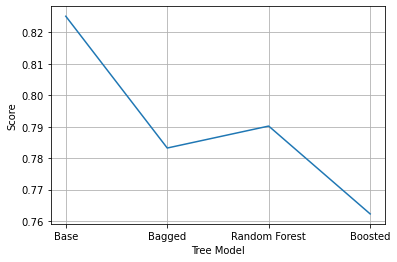

In [54]:
fig = plt.figure()

plt.plot(summary_stat['Tree Model'], summary_stat['Score'])
plt.xlabel('Tree Model')
plt.ylabel('Score')
plt.grid()
plt.show()

It seems the base model still has the highest score, followed by random forest, bagged, and lastly, boosted tree. In the next sections, the random forest model is further explored.

### Section 5 - Random Forest Feature Selections
In this section, features were ranked based on the random forest model (below).

In [55]:
# Feature importance from random from the forest model

feature_imp = {'Feature': features, 'Importance': pd.Series(Randomforest.feature_importances_).sort_values(ascending=False)}
feature_imp = pd.DataFrame(feature_imp)
feature_imp

,Feature,Importance
1,Pclass,0.539649
0,Sex,0.141110
5,Age,0.133100
2,SibSp,0.099307
6,Parch,0.035289
4,Fare,0.031281
3,Embarked,0.020265


Above, it is clear that whether a passenger survived or not depended heavily on the class ('Pclass'), 'Sex', and 'Age'. In contrast, the embarkation port ('Embarked'), 'Fare', and the number of parent / children ('Parch') did not contribute as much as the top 3 features.
### Section 6 - Random Forest n-estimators & max_depth Tuning
Since the random forest model was the next best model after the base model (based on the accuracy score), further investigations were carried as to whether it can be improved by tuning the n_estimators & max_depth numbers.
</br> Below, the scores are calculated based on the validation set & then plotted against the n_estimators & max_depth numbers.

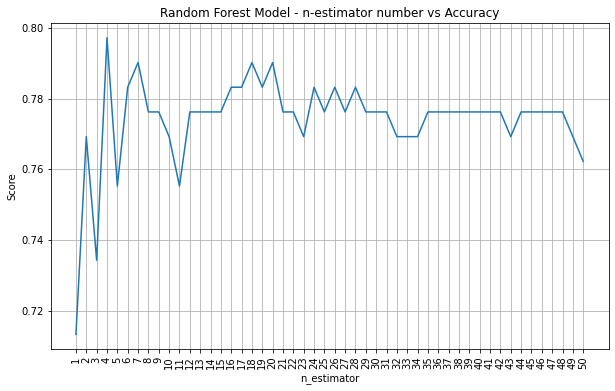

In [56]:
# Random Forest model - n-estimators number tuning
n_estimator_no = range(1,51)
rf_score_n = []

for n in n_estimator_no:
    Randomforest = RandomForestClassifier(n_estimators=n,random_state=r)
    Randomforest.fit(x_train,y_train)
    rf_score = Randomforest.score(x_val, y_val)
    rf_score_n.append(rf_score)

fig = plt.figure(figsize=(10,6))
plt.plot(n_estimator_no, rf_score_n)
plt.ylabel("Score")
plt.xlabel("n_estimator")
plt.title('Random Forest Model - n-estimator number vs Accuracy')
plt.xticks(n_estimator_no, rotation=90)
plt.grid()
plt.show()


From the plot above, we can see that the highest score was reached with n_estimators number of 4. This is then applied below to determine the optimum depth.

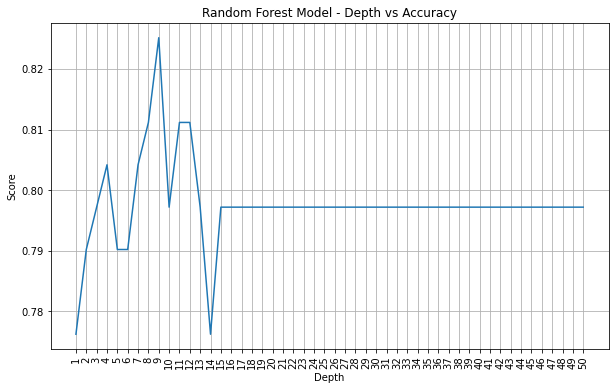

In [57]:
# Random Forest model
max_depth_no = range(1,51)
rf_score_n = []

for m in max_depth_no:
    Randomforest = RandomForestClassifier(n_estimators=4, max_depth=m, random_state=r)
    Randomforest.fit(x_train,y_train)
    rf_score = Randomforest.score(x_val, y_val)
    rf_score_n.append(rf_score)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(max_depth_no, rf_score_n)
plt.ylabel("Score")
plt.xlabel("Depth")
plt.title('Random Forest Model - Depth vs Accuracy')
plt.xticks(max_depth_no, rotation=90)
plt.grid()
plt.show()

From the plots above, based on calculations on the validation set, an improved accuracy score may be achieved on the test set with n_estimators = 4 and max_depth = 9. With this knowledge, the optimised random forest model is now applied on the test set (below).

In [58]:
# Optimised Random Forest model
y_test = y_test.ravel() 
Randomforest1 = RandomForestClassifier(n_estimators=4, max_depth=9, random_state=r)
Randomforest1.fit(x_test,y_test)

print(f'The accuracy of the random forest model on test data with the optimised n-estimators & max_depth numbers is: {Randomforest1.score(x_test, y_test)}')

The accuracy of the random forest model on test data with the optimised n-estimators & max_depth numbers is: 0.958041958041958


The accuracy of this optimised random forest model on the test set is 0.958, which is better than the accuracy of the base model (around 0.85).

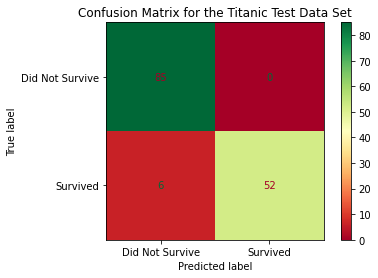

In [59]:
rf1_pred = Randomforest1.predict(x_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_mtx = confusion_matrix(y_test, rf1_pred)

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(6,4))
display = ConfusionMatrixDisplay(conf_mtx, display_labels=['Did Not Survive', 'Survived'])
ax.set(title='Confusion Matrix for the Titanic Test Data Set')
display.plot(ax=ax, cmap='RdYlGn')
plt.show()

From the confusion matrix above, we can see that only 6 entries out of the 143 entries in the test data set (4.2%) were mis-classified. This adds up to the accuracy score of 95.8% calculated above.